# Comparison of GRU, BGRU, BGRU-ATT, LSTM, BLSTM, BLSTM-ATT, BLSTM-TRA, BGRU-ATT models for wind speed prediction

Mahmood Karimi

created: 27 Jul 2022
updated: 14 Aug 2022

# Importing Packages

In [1]:
#!pip install attention

In [2]:
# Data wrangling
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt 

# Date wrangling
import datetime
import time
from datetime import datetime

# Math operations
import numpy as np
from scipy.stats import spearmanr
from scipy.stats import pearsonr


from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from attention import Attention
from keras.utils.vis_utils import plot_model

In [3]:
# Set random seed to get the same result after each time running the code
tf.random.set_seed(1234)

In [4]:
# tf.test.gpu_device_name()

In [5]:
# mount the data set from google drive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [6]:
# %cd /content/gdrive/MyDrive/wind-speed/

# Exploratory data analysis

## Data loading and cleansing

In [7]:
dd= pd.read_csv('dataset-daily.csv', skiprows=1)
dd.columns = ['date', 'temp_mean', 'pressure', 'wind_direction', 'wind_speed']
# convert date column
dd.date = [datetime.strptime(str(x), '%Y%m%d').date() for x in dd.date]
# sort by date column
dd.sort_values('date', inplace=True)
print('First 5 rows of dataset:\n')
print(dd.head())
print(f'\n There is {len(dd)} data points in the dataset.')

First 5 rows of dataset:

         date  temp_mean   pressure  wind_direction  wind_speed
0  1995-01-01        2.7   990.6667             263         6.7
1  1995-01-02        0.6  1000.7083             301         4.1
2  1995-01-03       -0.3  1027.3750             355         3.2
3  1995-01-04       -2.8  1035.9584              86         1.6
4  1995-01-05       -5.1  1034.5416             124         3.5

 There is 3653 data points in the dataset.


In [8]:
# check for any null values
dd.isna().sum()

date              0
temp_mean         0
pressure          0
wind_direction    0
wind_speed        0
dtype: int64

## Descriptive Statistics

<AxesSubplot:title={'center':'Boxplot of wind speed'}>

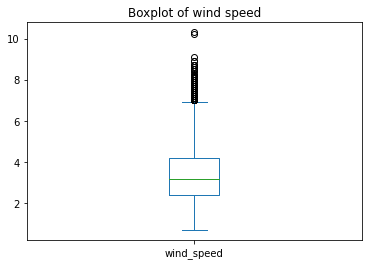

In [9]:
dd.wind_speed.plot(kind='box', title='Boxplot of wind speed')

In [10]:
features = [ 'wind_speed', 'temp_mean', 'pressure', 'wind_direction']
dd[features].describe()

,wind_speed,temp_mean,pressure,wind_direction
count,3653.000000,3653.000000,3653.000000,3653.000000
mean,3.463674,10.728881,1015.565916,200.673145
std,1.457985,7.985796,9.211292,90.742302
min,0.700000,-13.700000,984.416700,0.000000
25%,2.400000,4.400000,1009.791700,122.000000
50%,3.200000,10.900001,1016.041700,219.000000
75%,4.200000,17.200000,1021.333300,273.000000
max,10.300000,30.600000,1045.000000,359.000000


## Daily plots

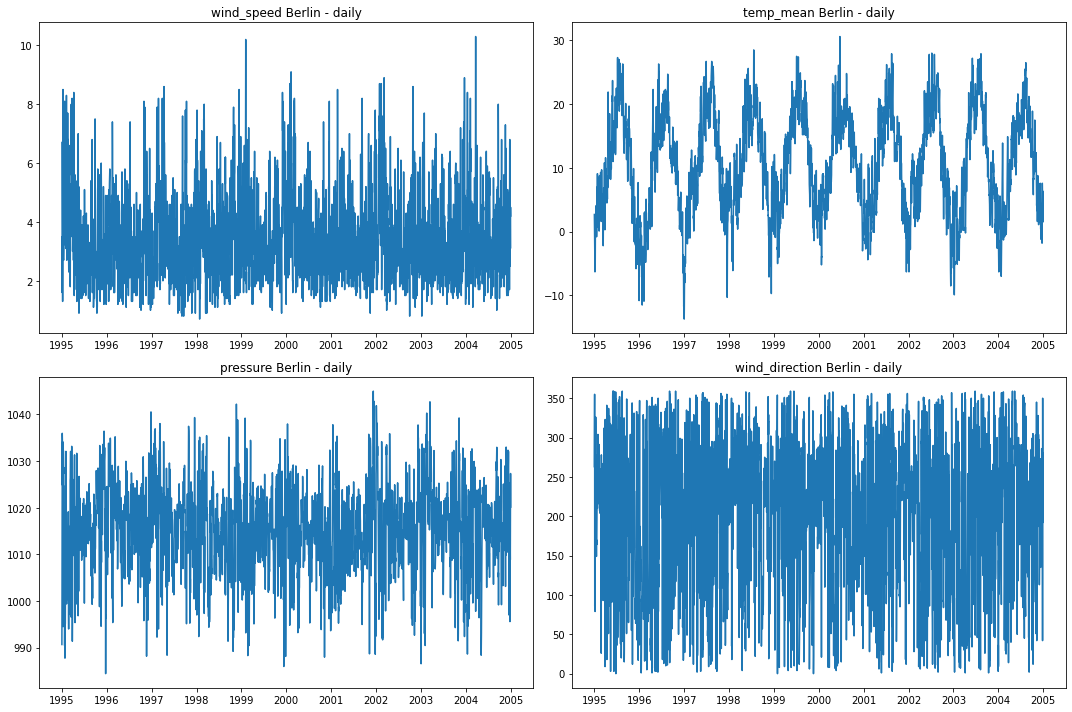

In [11]:
fig, axes = plt.subplots(
    nrows=2, 
    ncols=2, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

for i, feature in enumerate(features):
    axes[i // 2, i % 2].plot(dd.date, dd[feature])
    axes[i // 2, i % 2].set_title(f'{feature} Berlin - daily')
        
plt.tight_layout()

plt.show()

## Feature Engineering

<AxesSubplot:title={'center':'wind_speed'}, xlabel='dow'>

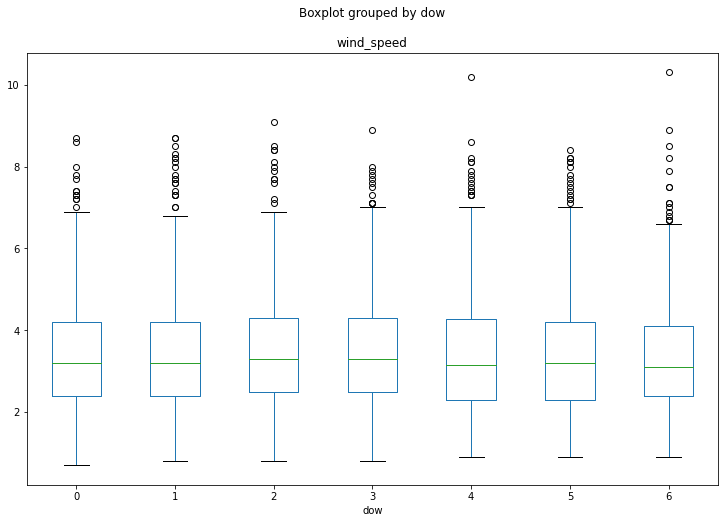

In [12]:
# Extract the day of week
dd['dow'] = [x.weekday() for x in dd['date']]
dd.boxplot('wind_speed', by='dow', figsize=(12, 8), grid=False)

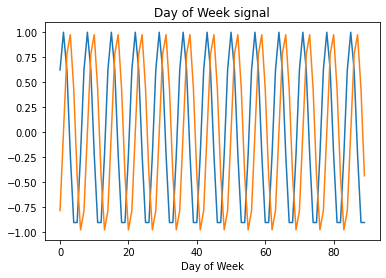

In [13]:
# Calculate angular distance
dd['dow_sin'] = np.sin(dd['dow'] * (2 * np.pi / 7))
dd['dow_cos'] = np.cos(dd['dow'] * (2 * np.pi / 7))

# Plot for first 3 month
plt.plot(np.array(dd['dow_cos'])[:90])
plt.plot(np.array(dd['dow_sin'])[:90])
plt.xlabel('Day of Week')
plt.title('Day of Week signal')
plt.show()

<AxesSubplot:title={'center':'wind_speed'}, xlabel='month'>

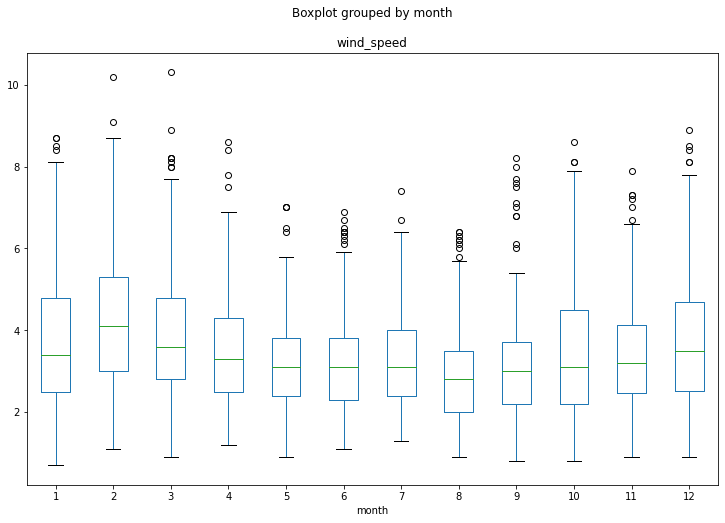

In [14]:
# Extracting the month of the year 
dd['month'] = [x.month for x in dd['date']]
dd.boxplot('wind_speed', by='month', figsize=(12, 8), grid=False)

In [15]:
# Extracting the timestamp from the datetime object 
dd['timestamp'] = [time.mktime(x.timetuple()) for x in dd['date']]

# Seconds in day 
s = 24 * 60 * 60 

# Seconds in year 
year = (365.25) * s

dd['month_cos'] = [np.cos((x) * (2 * np.pi / year)) for x in dd['timestamp']]
dd['month_sin'] = [np.sin((x) * (2 * np.pi / year)) for x in dd['timestamp']]

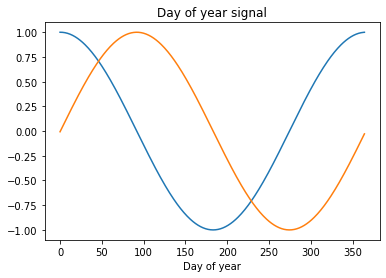

In [16]:
# Ploting the first year
plt.plot(np.array(dd['month_cos'])[:365])
plt.plot(np.array(dd['month_sin'])[:365])
plt.xlabel('Day of year')
plt.title('Day of year signal')
plt.show()

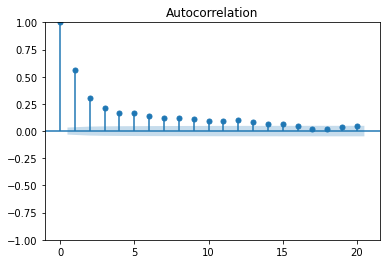

In [17]:
# Add features for previous days wind speed

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(dd['wind_speed'], lags=20)

dd['speed_1'] = dd['wind_speed'].shift(1, fill_value=0)
dd['speed_2'] = dd['wind_speed'].shift(2, fill_value=0)
dd['speed_3'] = dd['wind_speed'].shift(3, fill_value=0)

In [18]:
# Add features for mean of wind speed

dd['speed_mean_2'] = dd['wind_speed'].rolling(window=2).mean()
dd['speed_mean_3'] = dd['wind_speed'].rolling(window=3).mean()
dd['speed_mean_4'] = dd['wind_speed'].rolling(window=4).mean()

dd = dd.fillna(0)

In [19]:
features = ['wind_speed', 'temp_mean', 'pressure', 'wind_direction', 
            'month_cos', 'month_sin', 
            'speed_1', 'speed_2', 'speed_3', 
            'speed_mean_2', 'speed_mean_3', 'speed_mean_4'
           ]
# features = ['wind_speed', 'wind_direction', 'speed_1', 'speed_2', 'speed_3', 'speed_mean_3', 'speed_mean_7']

print('Pearson correlation and p-value:')
for col in features:
  cr = pearsonr(dd['wind_speed'], dd[col])
  print(f'{col:>15}: {round(cr[0], 2)}   {round(cr[1], 3)}')
print('')
print('All input variables exhibit a meaningful correlation with wind speed because the p-values are less than 0.01')
print('dow_sin, dow_cos not used because their p-value was larger that 0.01')

Pearson correlation and p-value:
     wind_speed: 1.0   0.0
      temp_mean: -0.15   0.0
       pressure: -0.34   0.0
 wind_direction: 0.22   0.0
      month_cos: 0.19   0.0
      month_sin: 0.12   0.0
        speed_1: 0.56   0.0
        speed_2: 0.3   0.0
        speed_3: 0.21   0.0
   speed_mean_2: 0.88   0.0
   speed_mean_3: 0.77   0.0
   speed_mean_4: 0.69   0.0

All input variables exhibit a meaningful correlation with wind speed because the p-values are less than 0.01
dow_sin, dow_cos not used because their p-value was larger that 0.01


# Prepare data for model

In [20]:
df = dd[features]
# Split train data and test data
train_size = int(len(df)*0.8)

train_data = pd.DataFrame(df.loc[:train_size, features]) # we need data frame for scaling
test_data = pd.DataFrame(df.loc[train_size:, features])

In [21]:
# Scale data
scaler = MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [22]:
# global params
watch_back = 1
global_units = 5
global_epochs = 10

In [23]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        # print(f'i: {i} i+look_back: {i+look_back}')
        #print(v)
        # print([X[i+look_back][0]])
        Xs.append(v)
        ys.append([X[i+look_back][0]])
        
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train_scaled, watch_back)
X_test, y_test = create_dataset(test_scaled, watch_back)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (2922, 1, 12)
y_train.shape:  (2922, 1)
X_test.shape:  (730, 1, 12)
y_test.shape:  (730, 1)


# Create Models

## GRU

In [24]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer 
    model.add(GRU(units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model

model_gru = create_gru(global_units)
model_gru.build(input_shape = [watch_back, len(features)])
print(model_gru.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 5)              285       
                                                                 
 dropout (Dropout)           (None, 1, 5)              0         
                                                                 
 gru_1 (GRU)                 (None, 5)                 180       
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 471
Trainable params: 471
Non-trainable params: 0
_________________________________________________________________
None


## Bi-Directional GRU (BGRU)

In [25]:
# Create Bi-Directional GRU
def create_bigru(units):
    model = Sequential()
    model.add(Bidirectional(GRU(units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]])))
    model.add(Dropout(0.2))
    # Hidden layer
    model.add(Bidirectional(GRU(units = units)))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model

model_bigru = create_bigru(global_units)
model_bigru.build(input_shape = [None, watch_back, len(features)])
print(model_bigru.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 10)            570       
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 1, 10)             0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 10)               510       
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,091
Trainable params: 1,091
Non-traina

## Bi-Directional GRU with Attention (BGRU-ATT)

In [26]:
# Create Bi-Directional GRU with Attention
def create_bigru_att(units):
    model = Sequential()
    model.add(Bidirectional(GRU(units = units, return_sequences = True, activation='selu',
                 input_shape = [X_train.shape[1], X_train.shape[2]])))   
    model.add(Attention(units))
    model.add(Dropout(0.2)) 
   
    model.add(Dense(units = 1, activation='selu')) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    # keras.optimizers.Adam(lr=0.001)
    return model

model_bigru_att = create_bigru_att(global_units)
model_bigru_att.build(input_shape = [None, watch_back, len(features)])
print(model_bigru_att.summary())
# plot_model(model_bigru_att, to_file='model_bigru_att.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 1, 10)            570       
 nal)                                                            
                                                                 
 attention (Attention)       (None, 5)                 200       
                                                                 
 dropout_4 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 776
Trainable params: 776
Non-trainable params: 0
_________________________________________________________________
None


## LSTM

In [27]:
# Create LSTM model
def create_lstm(units):
    model = Sequential()
    # Input layer 
    model.add(LSTM(units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(LSTM(units = units))                 
    model.add(Dropout(0.2))

    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model

model_lstm = create_lstm(global_units)
model_lstm.build(input_shape = [watch_back, len(features)])
print(model_lstm.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 5)              360       
                                                                 
 dropout_5 (Dropout)         (None, 1, 5)              0         
                                                                 
 lstm_1 (LSTM)               (None, 5)                 220       
                                                                 
 dropout_6 (Dropout)         (None, 5)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 586
Trainable params: 586
Non-trainable params: 0
_________________________________________________________________
None


## Bi-Directional LSTM (BLSTM)

In [28]:
# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model

model_bilstm = create_bilstm(global_units)
model_bilstm.build(input_shape = [watch_back, len(features)])
print(model_bilstm.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 1, 10)            720       
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 1, 10)             0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 10)               640       
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,371
Trainable params: 1,371
Non-trainable params: 0
_________________________________________________________________
None


## Bi-Directional LSTM with Attention

In [29]:
# Create Bi-Directional LSTM with Attention
def create_bilstm_att(units):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]])))
    model.add(Attention(units))
    model.add(Dropout(0.2)) 

    # Hidden layer
    # model.add(Bidirectional(LSTM(units = units)))
    # model.add(Attention(32))
    # model.add(Dropout(0.2))
    
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model

model_bilstm_att = create_bilstm_att(global_units)
model_bilstm_att.build(input_shape = [None, watch_back, len(features)])
print(model_bilstm_att.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 1, 10)            720       
 nal)                                                            
                                                                 
 attention_1 (Attention)     (None, 5)                 200       
                                                                 
 dropout_8 (Dropout)         (None, 5)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                                 
Total params: 926
Trainable params: 926
Non-trainable params: 0
_________________________________________________________________
None


## Transformer

In [30]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def create_transformer(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, 
                      mlp_units, dropout=0, mlp_dropout=0):

    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(units=1, activation="selu")(x)
    return keras.Model(inputs, outputs)

model_transformer = create_transformer(input_shape = X_train.shape[1:],
    head_size=256, num_heads=4, ff_dim=4, num_transformer_blocks=4, 
    mlp_units=[128], mlp_dropout=0.4, dropout=0.25)
model_transformer.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=1e-4))
print(model_transformer.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 12)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 1, 12)       24          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 1, 12)       52236       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

 mbda)                                                            'tf.__operators__.add_5[0][0]'] 
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 1, 12)       24          ['tf.__operators__.add_6[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv1d_6 (Conv1D)              (None, 1, 4)         52          ['layer_normalization_7[0][0]']  
                                                                                                  
 dropout_16 (Dropout)           (None, 1, 4)         0           ['conv1d_6[0][0]']               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 1, 12)        60          ['dropout_16[0][0]']             
          

## Bi-directional LSTM with Transformer

In [31]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def create_bilstm_tra(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, 
                      mlp_units, dropout=0, mlp_dropout=0, units=4):

    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
        
    # bidirectional lstm and connection to other part
    bx = Bidirectional(LSTM(units, return_sequences=True))(inputs)
    bx = Dense(1, activation='linear')(bx)
    # add layers
    x = bx + x

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(units=1, activation="selu")(x)
    return keras.Model(inputs, outputs)

model_bilstm_tra = create_bilstm_tra(input_shape = X_train.shape[1:],
    head_size=256, num_heads=4, ff_dim=4, num_transformer_blocks=4, 
    mlp_units=[128], mlp_dropout=0.4, dropout=0.25, units=global_units)
model_bilstm_tra.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=1e-4))
print(model_bilstm_tra.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1, 12)]      0           []                               
                                                                                                  
 layer_normalization_8 (LayerNo  (None, 1, 12)       24          ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 1, 12)       52236       ['layer_normalization_8[0][0]',  
 eadAttention)                                                    'layer_normalization_8[0][0]']  
                                                                                            

 ambda)                                                           'tf.__operators__.add_13[0][0]']
                                                                                                  
 layer_normalization_15 (LayerN  (None, 1, 12)       24          ['tf.__operators__.add_14[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv1d_14 (Conv1D)             (None, 1, 4)         52          ['layer_normalization_15[0][0]'] 
                                                                                                  
 dropout_25 (Dropout)           (None, 1, 4)         0           ['conv1d_14[0][0]']              
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 1, 10)       720         ['input_2[0][0]']                
 )        

## Bi-directional GRU with Transformer

In [32]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def create_bigru_tra(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, 
                      mlp_units, dropout=0, mlp_dropout=0, units=4):

    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
        
    # bidirectional gru and connection to other part
    bx = Bidirectional(GRU(units, return_sequences=True))(inputs)
    bx = Dense(1, activation='linear')(bx)
    # add layers
    x = bx + x

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(units=1, activation="selu")(x)
    return keras.Model(inputs, outputs)

model_bigru_tra = create_bigru_tra(input_shape = X_train.shape[1:],
    head_size=256, num_heads=4, ff_dim=4, num_transformer_blocks=4, 
    mlp_units=[128], mlp_dropout=0.4, dropout=0.25, units=global_units)
model_bigru_tra.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=1e-4))
print(model_bigru_tra.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1, 12)]      0           []                               
                                                                                                  
 layer_normalization_16 (LayerN  (None, 1, 12)       24          ['input_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_8 (MultiH  (None, 1, 12)       52236       ['layer_normalization_16[0][0]', 
 eadAttention)                                                    'layer_normalization_16[0][0]'] 
                                                                                            

 ambda)                                                           'tf.__operators__.add_22[0][0]']
                                                                                                  
 layer_normalization_23 (LayerN  (None, 1, 12)       24          ['tf.__operators__.add_23[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv1d_22 (Conv1D)             (None, 1, 4)         52          ['layer_normalization_23[0][0]'] 
                                                                                                  
 dropout_34 (Dropout)           (None, 1, 4)         0           ['conv1d_22[0][0]']              
                                                                                                  
 bidirectional_7 (Bidirectional  (None, 1, 10)       570         ['input_3[0][0]']                
 )        

# Fit Models

In [33]:
def fit_model(model, eps, model_name):
    print(f'Fitting model {model_name} with {eps} epochs....')
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = eps, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
    return history

history_gru = fit_model(model_gru, global_epochs, 'gru')
history_bigru = fit_model(model_bigru, global_epochs, 'bigru')
history_bigru_att = fit_model(model_bigru_att, global_epochs, 'bigru-att')
history_lstm = fit_model(model_lstm, global_epochs, 'lstm')
history_bilstm = fit_model(model_bilstm, global_epochs, 'bilstm')
history_bilstm_att = fit_model(model_bilstm_att, global_epochs, 'bilstm-att')
history_transformer = fit_model(model_transformer, global_epochs, 'transformer')
history_bilstm_tra = fit_model(model_bilstm_tra, global_epochs, 'bilstm_tra')
history_bigru_tra = fit_model(model_bigru_tra, global_epochs, 'bigru_tra')

Fitting model gru with 10 epochs....
Epoch 1/10
74/74 [==============================] - 4s 12ms/step - loss: 0.0445 - val_loss: 0.0208
Epoch 2/10
74/74 [==============================] - 0s 4ms/step - loss: 0.0259 - val_loss: 0.0206
Epoch 3/10
74/74 [==============================] - 0s 4ms/step - loss: 0.0244 - val_loss: 0.0199
Epoch 4/10
74/74 [==============================] - 0s 4ms/step - loss: 0.0243 - val_loss: 0.0195
Epoch 5/10
74/74 [==============================] - 0s 4ms/step - loss: 0.0225 - val_loss: 0.0189
Epoch 6/10
74/74 [==============================] - 0s 4ms/step - loss: 0.0219 - val_loss: 0.0185
Epoch 7/10
74/74 [==============================] - 0s 4ms/step - loss: 0.0215 - val_loss: 0.0182
Epoch 8/10
74/74 [==============================] - 0s 4ms/step - loss: 0.0209 - val_loss: 0.0177
Epoch 9/10
74/74 [==============================] - 0s 4ms/step - loss: 0.0203 - val_loss: 0.0174
Epoch 10/10
74/74 [==============================] - 0s 4ms/step - loss: 0.0200 

Fitting model bigru_tra with 10 epochs....
Epoch 1/10
74/74 [==============================] - 7s 23ms/step - loss: 0.0685 - val_loss: 0.0286
Epoch 2/10
74/74 [==============================] - 1s 12ms/step - loss: 0.0369 - val_loss: 0.0208
Epoch 3/10
74/74 [==============================] - 1s 12ms/step - loss: 0.0310 - val_loss: 0.0203
Epoch 4/10
74/74 [==============================] - 1s 12ms/step - loss: 0.0255 - val_loss: 0.0173
Epoch 5/10
74/74 [==============================] - 1s 12ms/step - loss: 0.0243 - val_loss: 0.0180
Epoch 6/10
74/74 [==============================] - 1s 12ms/step - loss: 0.0234 - val_loss: 0.0180
Epoch 7/10
74/74 [==============================] - 1s 11ms/step - loss: 0.0232 - val_loss: 0.0177
Epoch 8/10
74/74 [==============================] - 1s 11ms/step - loss: 0.0219 - val_loss: 0.0175
Epoch 9/10
74/74 [==============================] - 1s 12ms/step - loss: 0.0213 - val_loss: 0.0167
Epoch 10/10
74/74 [==============================] - 1s 12ms/step 

# Models Performance

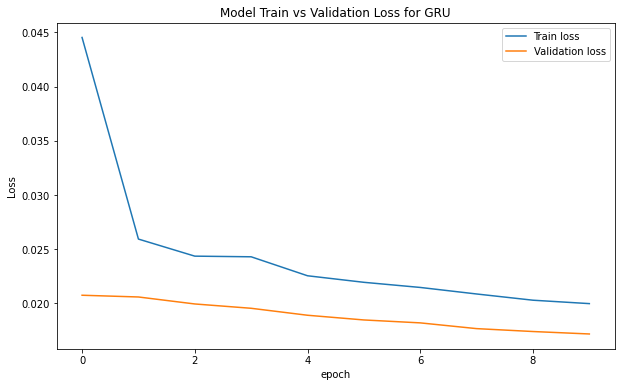

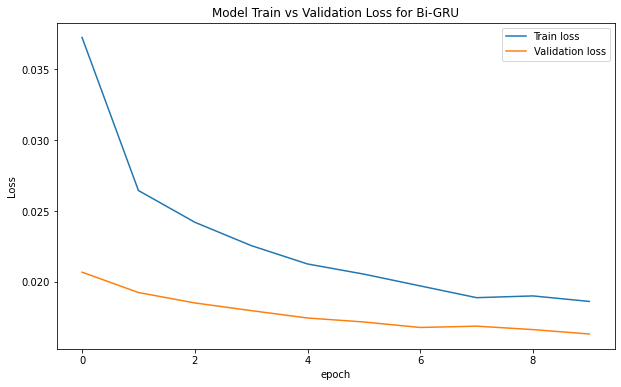

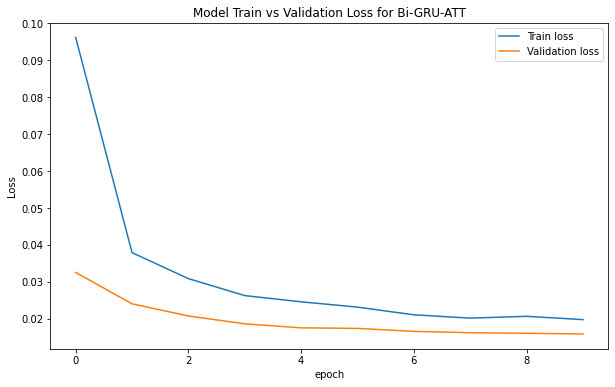

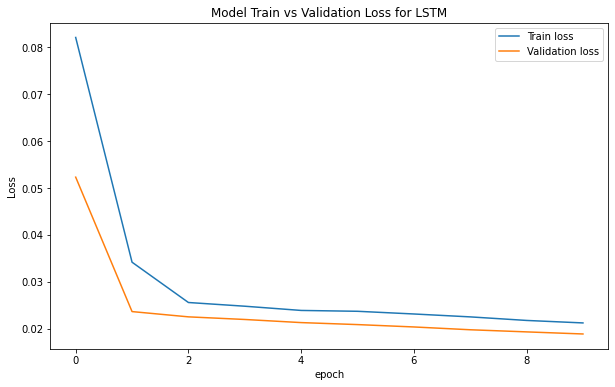

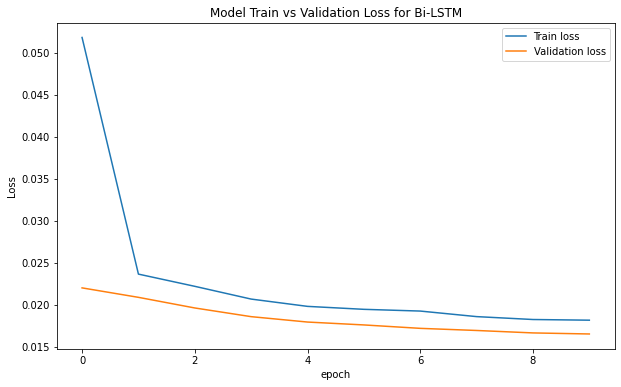

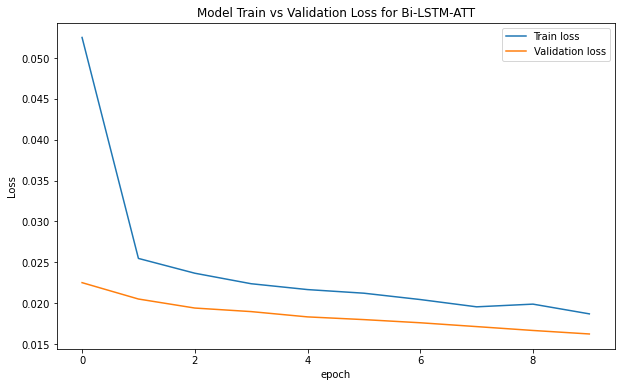

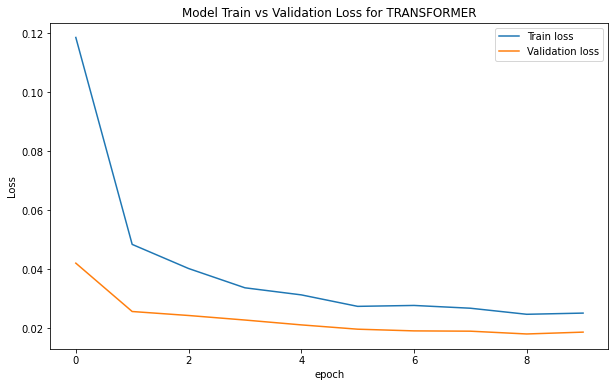

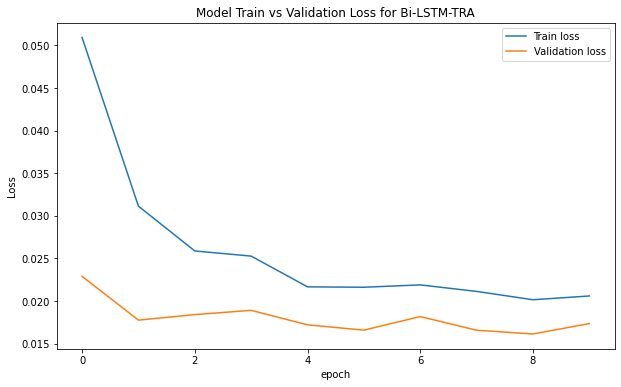

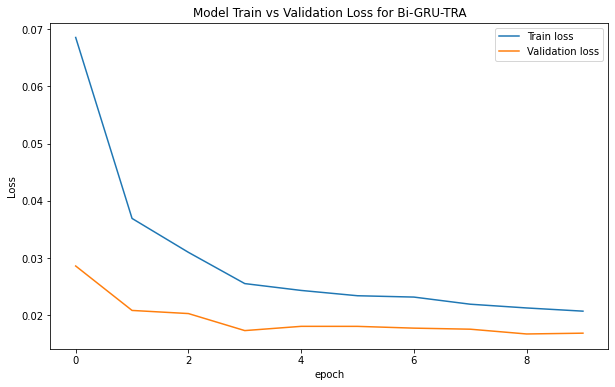

In [34]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.savefig('loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss(history_gru, 'GRU')
plot_loss(history_bigru, 'Bi-GRU')
plot_loss(history_bigru_att, 'Bi-GRU-ATT')
plot_loss(history_lstm, 'LSTM')
plot_loss(history_bilstm, 'Bi-LSTM')
plot_loss(history_bilstm_att, 'Bi-LSTM-ATT')
plot_loss(history_transformer, 'TRANSFORMER')
plot_loss(history_bilstm_tra, 'Bi-LSTM-TRA')
plot_loss(history_bigru_tra, 'Bi-GRU-TRA')

In [35]:
# Transform data back to original data space
def add_cols(a, n):
    if (n==0):
        return a
    b = np.zeros(shape = (len(a),n+1))
    fill = np.zeros(shape=(1,n))
    for i in range(len(a)):
        b[i] = np.append(a[i], fill[0])
    return(b)

y_test_sc = add_cols(y_test, len(features)-1)
y_test = scaler.inverse_transform(y_test_sc)[:, [0]]
y_train_sc = add_cols(y_train, len(features)-1)
y_train = scaler.inverse_transform(y_train_sc)[:, [0]]

In [36]:
# Make prediction
def prediction(model):
    prd = model.predict(X_test)
    prd_sc = add_cols(prd, len(features)-1)
    prd = scaler.inverse_transform(prd_sc)[:, [0]]
    return prd

prediction_gru = prediction(model_gru)
prediction_bigru = prediction(model_bigru)
prediction_bigru_att = prediction(model_bigru_att)
prediction_lstm = prediction(model_lstm)
prediction_bilstm = prediction(model_bilstm)
prediction_bilstm_att = prediction(model_bilstm_att)
prediction_transformer = prediction(model_transformer)
prediction_bilstm_tra = prediction(model_bilstm_tra)
prediction_bigru_tra = prediction(model_bigru_tra)

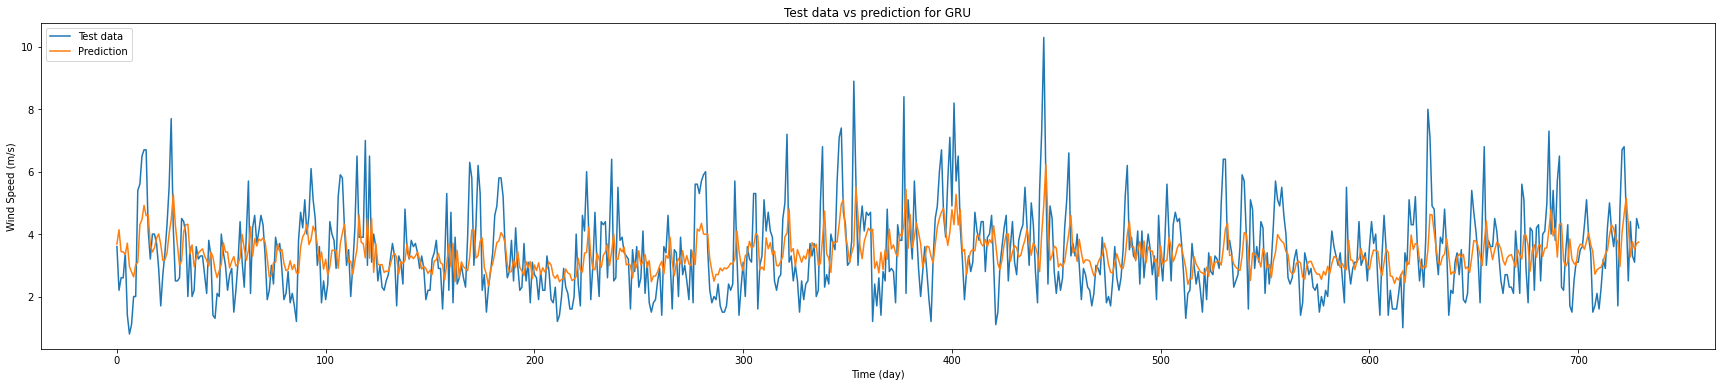

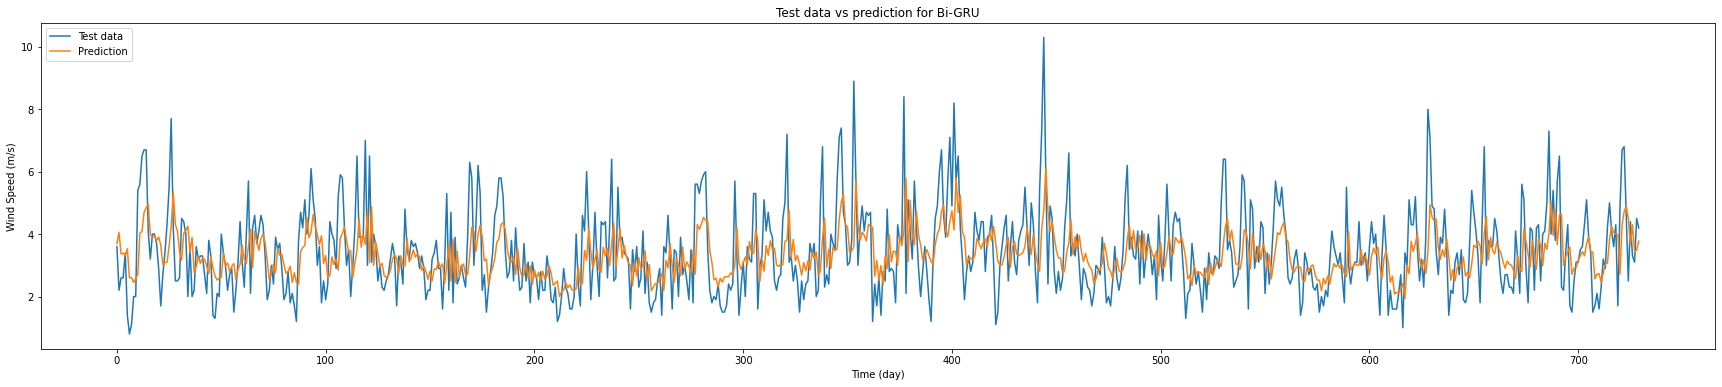

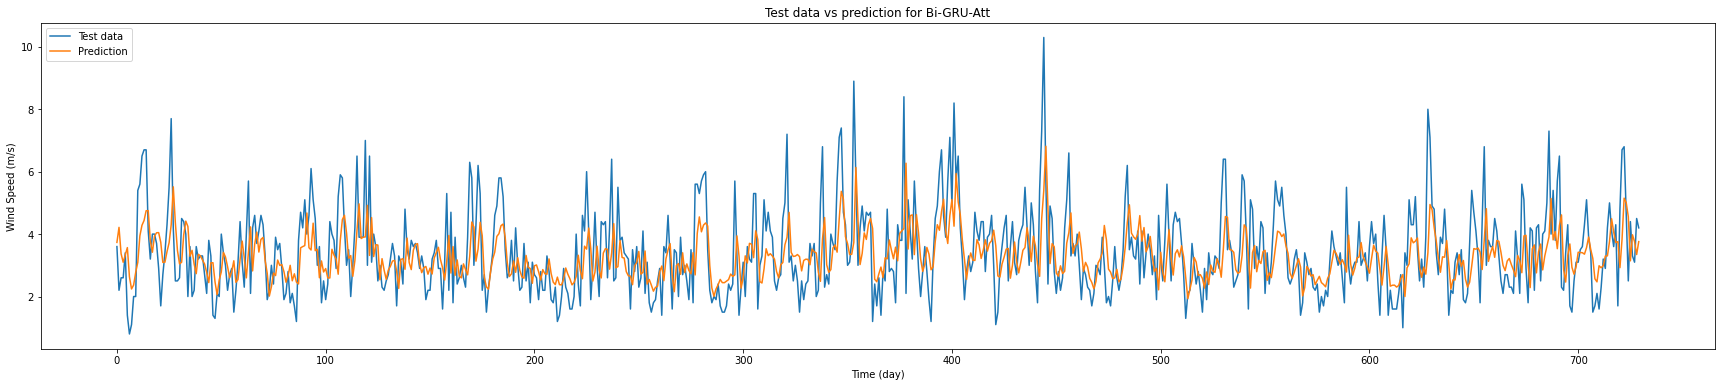

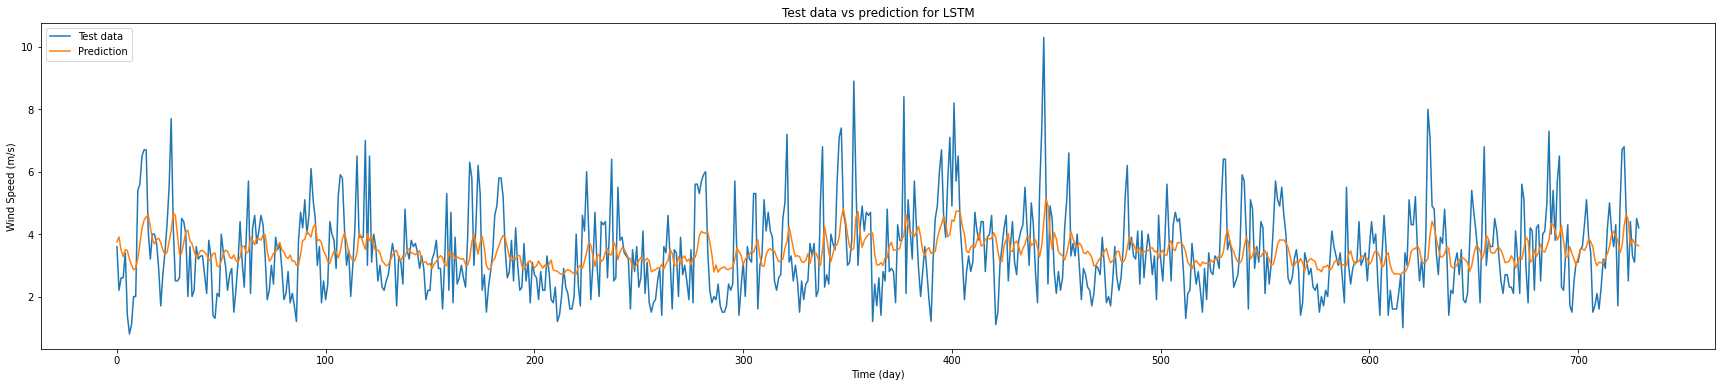

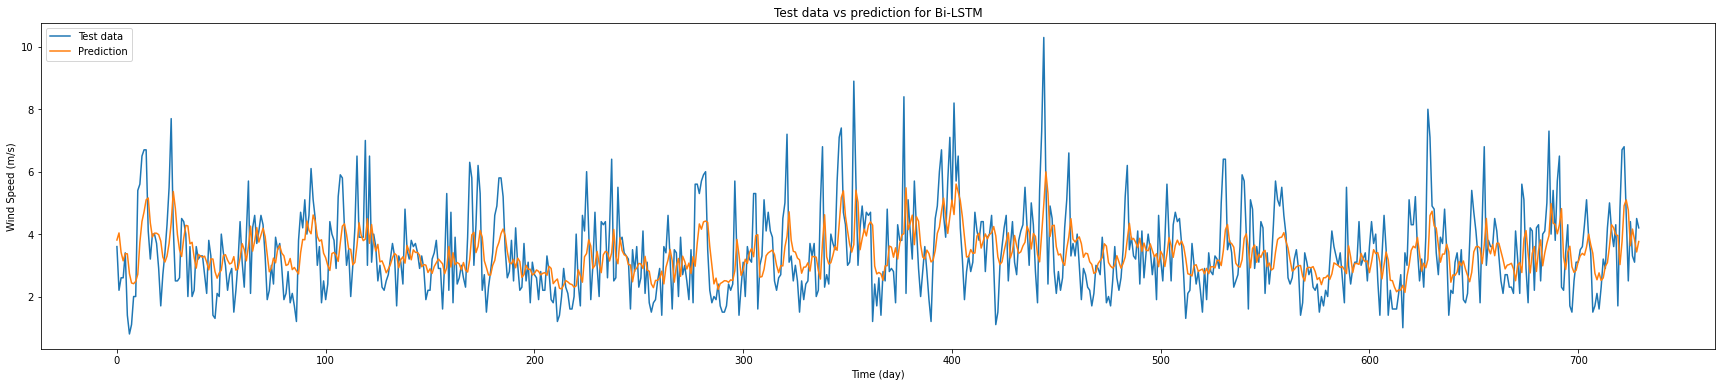

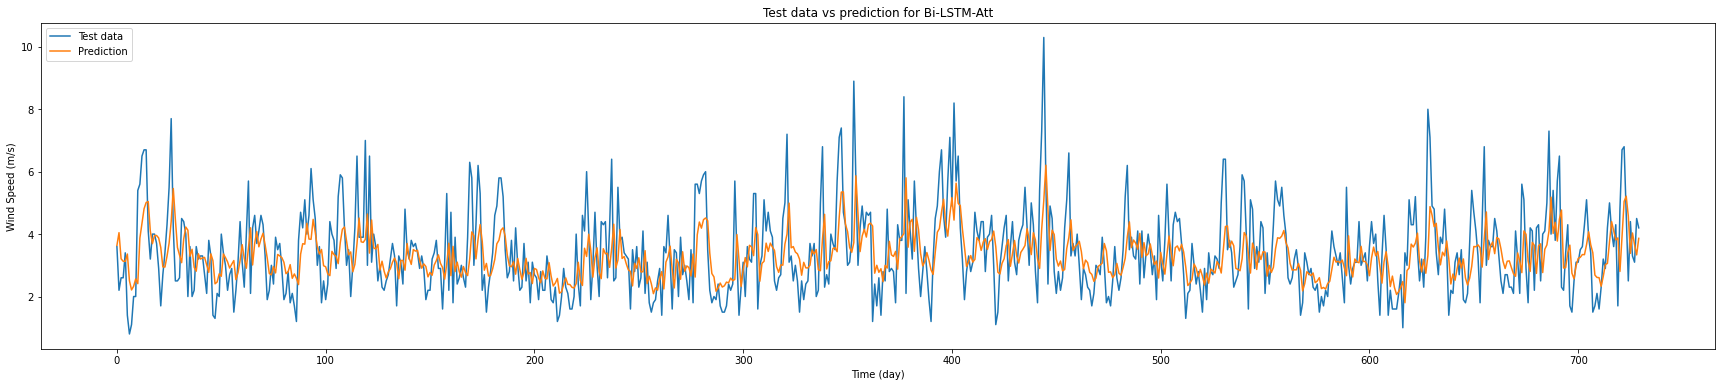

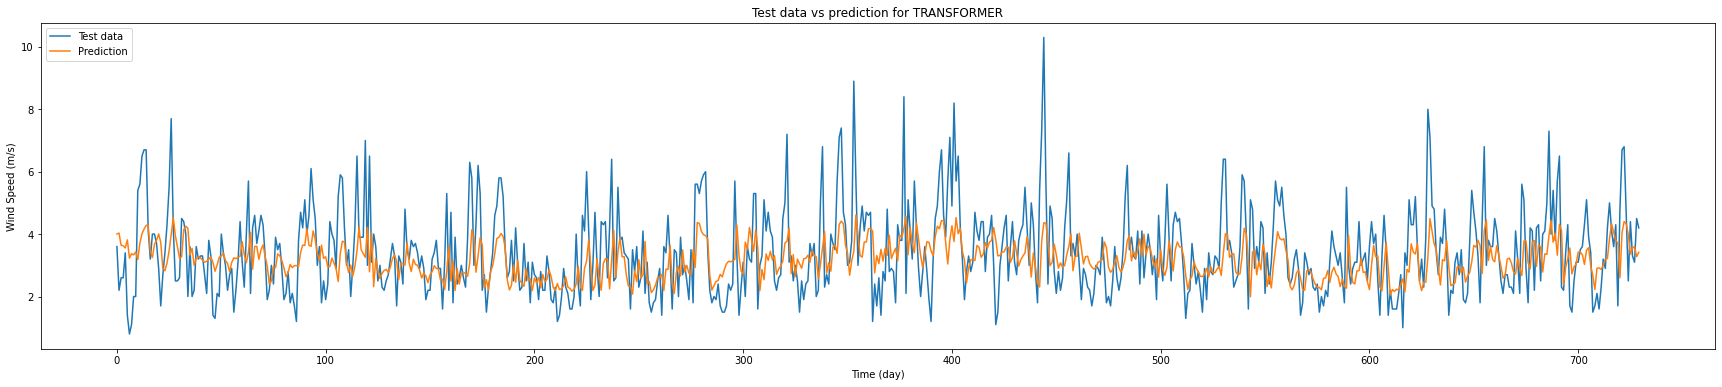

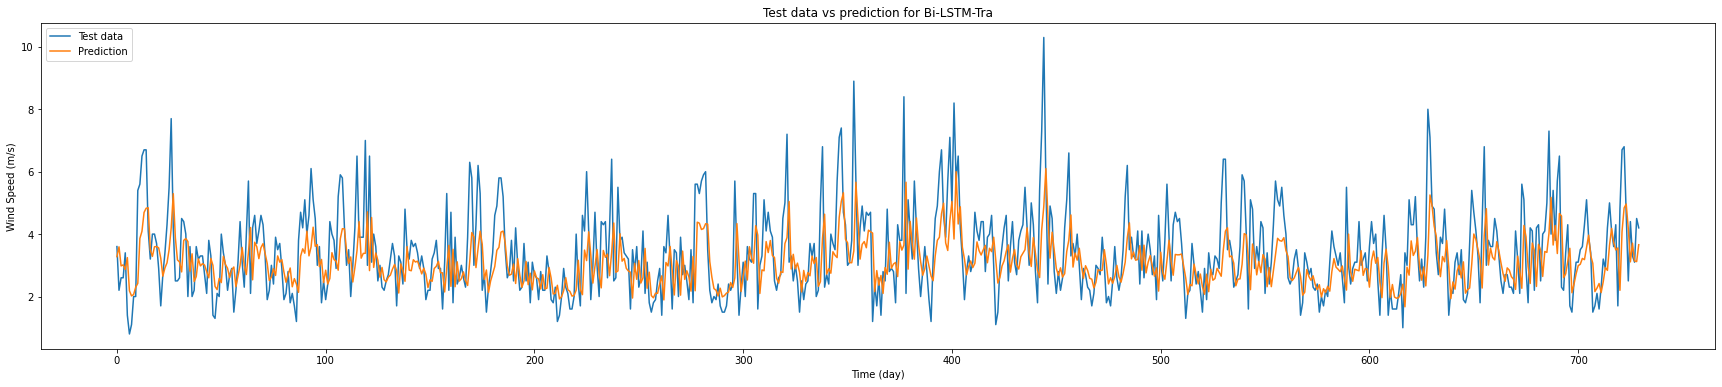

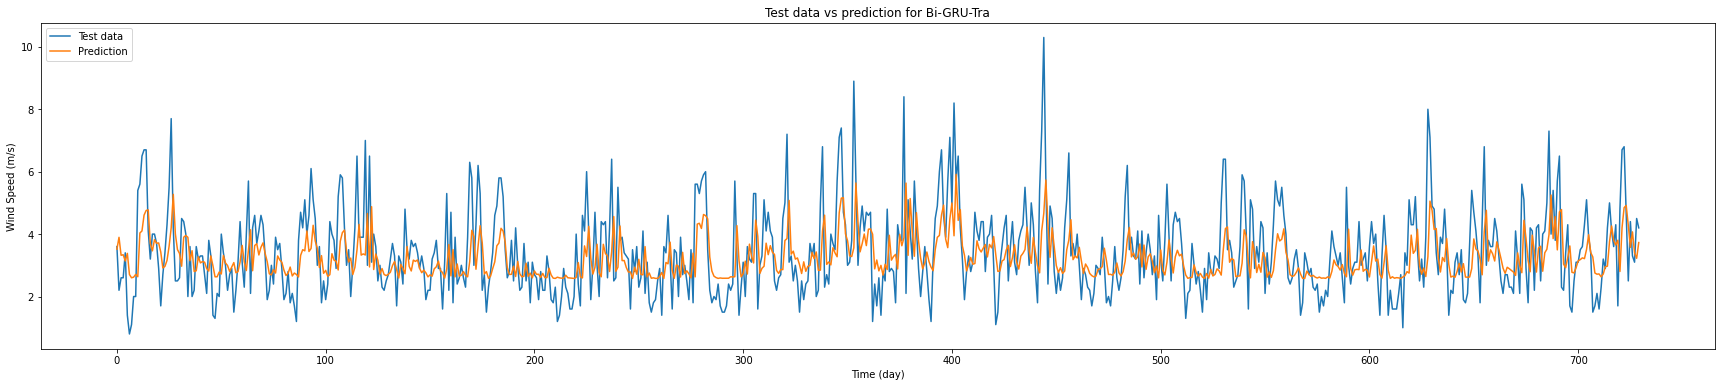

In [37]:
# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(30, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Wind Speed (m/s)')

plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_bigru, 'Bi-GRU', y_test)
plot_future(prediction_bigru_att, 'Bi-GRU-Att', y_test)
plot_future(prediction_lstm, 'LSTM', y_test)
plot_future(prediction_bilstm, 'Bi-LSTM', y_test)
plot_future(prediction_bilstm_att, 'Bi-LSTM-Att', y_test)
plot_future(prediction_transformer, 'TRANSFORMER', y_test)
plot_future(prediction_bilstm_tra, 'Bi-LSTM-Tra', y_test)
plot_future(prediction_bigru_tra, 'Bi-GRU-Tra', y_test)

In [46]:
# Calculate MAE and RMSE and CC

rdf = pd.DataFrame({'Model': pd.Series(dtype='str'),
                   'RMSE(m/s)': pd.Series(dtype='float'),
                   'MAE(m/s)': pd.Series(dtype='float'),
                   'CC': pd.Series(dtype='float')})

def evaluate_prediction(predictions, actual, model_name, rdfl):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    corr, _ = pearsonr(np.concatenate(predictions), np.concatenate(actual))
    model_df = {'Model': model_name, 'RMSE(m/s)': round(rmse,2), 'MAE(m/s)': round(mae, 2), 'CC': round(corr, 2)}
    rdfl = rdfl.append(model_df, ignore_index=True)
    return rdfl

    #print(model_name + ':')
    #print('Root Mean Square Error: {:.4f}'.format(rmse))
    #print('Mean Absolute Error: {:.4f}'.format(mae))
    #print('Pearson correlation coefficient: %.3f' % corr)
    #print('')
    return [rmse, mae, corr]

rdf = evaluate_prediction(prediction_gru, y_test, 'GRU', rdf)
rdf = evaluate_prediction(prediction_bigru, y_test, 'Bi-GRU', rdf)
rdf = evaluate_prediction(prediction_bigru_att, y_test, 'Bi-GRU-ATT', rdf)
rdf = evaluate_prediction(prediction_lstm, y_test, 'LSTM', rdf)
rdf = evaluate_prediction(prediction_bilstm, y_test, 'Bi-LSTM', rdf)
rdf = evaluate_prediction(prediction_bilstm_att, y_test, 'Bi-LSTM-ATT', rdf)
rdf = evaluate_prediction(prediction_transformer, y_test, 'TRANSFORMER', rdf)
rdf = evaluate_prediction(prediction_bilstm_tra, y_test, 'Bi-LSTM-TRA', rdf)
rdf = evaluate_prediction(prediction_bigru_tra, y_test, 'Bi-GRU-TRA', rdf)

print(rdf)

         Model  RMSE(m/s)  MAE(m/s)    CC
0          GRU       1.22      0.94  0.47
1       Bi-GRU       1.22      0.93  0.46
2   Bi-GRU-ATT       1.21      0.93  0.48
3         LSTM       1.27      0.98  0.39
4      Bi-LSTM       1.23      0.95  0.45
5  Bi-LSTM-ATT       1.20      0.92  0.49
6  TRANSFORMER       1.27      0.96  0.42
7  Bi-LSTM-TRA       1.25      0.93  0.49
8   Bi-GRU-TRA       1.22      0.93  0.48
